# Practical session demo #2 (solutions)

In this session, we are covering the following:
* Implement your own sampling strategy
* Implement your own optimizer
* How to add your implementations to the framework

First we are downloading some objects if you might not finish the exercise in time:

In [1]:
!wget -q -cO - https://github.com/mpvanderschelling/F3DASM_practical/blob/main/session2/exercise_gridsearch_samples.obj?raw=true > exercise_gridsearch_samples.obj

Now we are importing the f3dasm package. If this is not present, install it from the PyPi index

In [2]:
# If f3dasm is not found, install the correct version from pip
try:
    import f3dasm
except ModuleNotFoundError:
    %pip install f3dasm==0.2.7 --quiet
    import f3dasm

Note: you may need to restart the kernel to use updated packages.


2022-11-30 15:00:20.398915: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-30 15:00:20.562861: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-30 15:00:21.254717: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.1/lib64
2022-11-30 15:00:21.254785: W tensorflow/compiler/xla/stream

Also, we have to make sure that we have the right version!

In [3]:
# Check if you got the right version, otherwise uninstall this version!

import os

if f3dasm.__version__ != '0.2.7':
    %pip uninstall -y f3dasm
    os._exit(00)
    # The kernel will be restarted and you need to run the notebook again!

In [4]:
print(f"Your f3dasm version is {f3dasm.__version__}!")

Your f3dasm version is 0.2.7!


import some other packages:

In [5]:
import numpy as np
from dataclasses import dataclass
from typing import Tuple
import copy

We specify a seed:

In [6]:
seed = 42

## Implement your own sampler

In this part of the tutorial, we are going to take a closer look at the `f3dasm.SamplingInterface`

### What happens inside the samples

By executing the `get_samples()` function, the following happesn

* We split the parameters in the designspace to each of the categories (`ContinuousParameter`, `DiscreteParameter`, `CategoricalParameter`, `ConstantParameter`)
* Samples from the discrete and categorical dimensions are by default randomly sampled (`_sample_discrete()` and `_sample_categorical()`)
* Samples from the constant parameter are, well .. constant!
* Samples from the continuous parameters get samples by the samplingstrategy implemente by the `sample_continuous()` function
* All samples are concatenated to a numpy array
* The samples are converted to a `f3dasm.Data` object!



### Implement a new samples

Implementing a new sampler goes as follows

* We create a new class inhereting from the `f3dasm.SamplingInterface` class
* We have to implement our own `sample_continuous()` function:

> Note we can also implement sampling strategies for all the other parameters but this is not necessary

This `sample_continuous` function inputs the number of samples you want to create and returns a 2D numpy-array with the coordinates of those samples

In [7]:
class NewSampler(f3dasm.SamplingInterface):
    def sample_continuous(self, numsamples: int) -> np.ndarray:
        ...

### Example: GridSearch

We are going to create a new continuous sampling strategy.

The idea of grid search, or parameter sweep, is to equally partition the design space to a grid and sample on these grid points.

The proposed strategy is as follows:
* We will sample a $n$-dimensional grid of points according to the number of samples requested
* If we have sample budget left, these points are randomly sampled and added to the gridpoints

![Grid Search example](https://upload.wikimedia.org/wikipedia/commons/b/b6/Hyperparameter_Optimization_using_Grid_Search.svg)

I'll help you through the mathematics so that you have to implement it:

If we have a unit 2D grid and we want to sample 18 points according to this grid search strategy, we will have a grid of 4x4 and 2 points left.
The points per dimension is therefore $4$. We can calculate this `points_per_dimension` by taking the $n^{\mathrm{th}}$-root of `numsamples`:

In [8]:
numsamples = 18
dimensions = 2

points_per_dimension = int(np.power(numsamples, 1/dimensions))
print(f"Points per dimension is: {points_per_dimension}")

Points per dimension is: 4


The number of "leftover samples" is just substracting all the grid points from the total number of samples

In [9]:
leftovers = numsamples - points_per_dimension**dimensions
print(f"Leftover samples is: {leftovers}")

Leftover samples is: 2


To calculate the spacing for one dimension, we create a `spacing_list` denoting the coordinate of the grid points

> We will start at the origin, so we substract $1$ from `points_per_dimension`:

In [10]:
spacing_list = [i*(1/(points_per_dimension-1)) for i in range(points_per_dimension)]
print(spacing_list)

[0.0, 0.3333333333333333, 0.6666666666666666, 1.0]


> Be aware that if the number of samples is less or equal than the $dim^2$, you will divide by $0$!

In order to create all grid points, we will consult the `product` function from the `itertools` library

In [11]:
from itertools import product

samples_gridsearch = np.array([item for item in product(spacing_list, repeat=dimensions)])
print(samples_gridsearch)

[[0.         0.        ]
 [0.         0.33333333]
 [0.         0.66666667]
 [0.         1.        ]
 [0.33333333 0.        ]
 [0.33333333 0.33333333]
 [0.33333333 0.66666667]
 [0.33333333 1.        ]
 [0.66666667 0.        ]
 [0.66666667 0.33333333]
 [0.66666667 0.66666667]
 [0.66666667 1.        ]
 [1.         0.        ]
 [1.         0.33333333]
 [1.         0.66666667]
 [1.         1.        ]]


`samples_gridsearch` denotes the samples that are created by the equally spaced grid!

***
**Exercise #1**

Implement the grid search sampler in the `f3dasm` framework

* Create the grid samples and make sure you are not using more points than the `numsamples`
* If you have remaining samples, sample them randomly and add them to the total generated samples
* If `numsamples` <= $dim^2$, you may raise a `ValueError`
* In order to test your implementation, sample $123$ points on a 2D continuous space with bounds $-1.0$ and $1.0$.
***

Some helpful functions:

* Remember, a sampler is initialized with a `f3dasm.DesignSpace` and a `seed`
* A list of the continuous parameters can be accessed with `self.design.get_continuous_input_parameters()`
* You can sample in a unit hypercube and stretch the samples to the boundaries of the designspace with the `self._stretch_samples(samples)` function

In [12]:
## YOUR CODE HERE ##

(<Figure size 640x480 with 1 Axes>, <AxesSubplot:xlabel='x0', ylabel='x1'>)

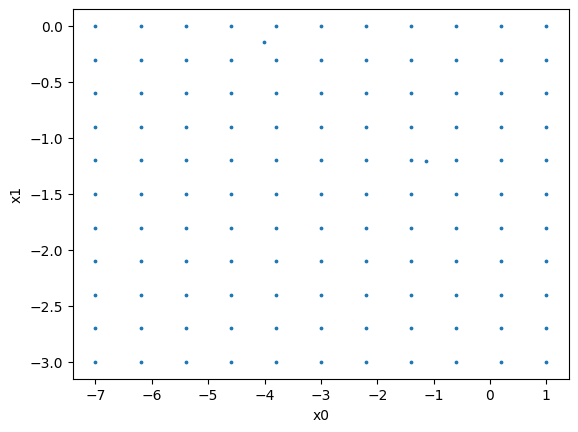

In [27]:
## SOLUTION ##

class GridSearch(f3dasm.SamplingInterface):
    """Explanation of the code
    
    Parameters
    ----------
        documentation
    """
    def sample_continuous(self, numsamples: int) -> np.ndarray:
        continuous = self.design.get_continuous_input_parameters()
        dimensions = len(continuous)

        # Check if we have sufficient samples
        if numsamples <= dimensions**2:
            raise ValueError("number of samples is less than the square of the dimensionality!")

        points_per_dimension = int(np.power(numsamples, 1/dimensions))
        leftovers = numsamples - points_per_dimension**dimensions

        spacing_list = [i*(1/(points_per_dimension-1)) for i in range(points_per_dimension)]

        samples_gridsearch = np.array([item for item in product(spacing_list, repeat=dimensions)])
        samples_leftover = np.random.uniform(size=(leftovers, dimensions))

        # Concatenate the samples
        samples = np.concatenate([samples_gridsearch,samples_leftover])

        # Stretch the samples to the boundaries of the search space
        samples = self._stretch_samples(samples)

        return samples

dimensionality = 2
design = f3dasm.make_nd_continuous_design(bounds=np.array([[-7., 1.], [-3., 0.]]), dimensionality=dimensionality)

grid_sampler = GridSearch(design=design, seed=seed)
samples = grid_sampler.get_samples(numsamples=123)
samples.plot()

# f3dasm.write_pickle('exercise_gridsearch_samples', samples)

_If you are not able to finish this exercise on time, you may import the samples by uncommenting the following line:_

In [14]:
# samples = f3dasm.read_pickle('exercise_gridsearch_samples')

## Integrate your sampler into the framework

The next step is to integrate your sampler to the f3dasm code so that others can access them. 

### Adding the sampler to the list of samplers

In order to check if your implementation is compatible, you can add it to the list of implemented samplers
All the samplers can be accessed in a list by calling `f3dasm.sampling.SAMPLERS` 

> This list is created in the sub-module initializer`f3dasm.sampling.__init__.py`

In [15]:
f3dasm.sampling.SAMPLERS

[f3dasm.sampling.latinhypercube.LatinHypercube,
 f3dasm.sampling.randomuniform.RandomUniform,
 f3dasm.sampling.sobolsequence.SobolSequence]

### Adding the sampler to the source code

You can create a new `.py` file in the `/f3dasm/sampling/` folder in the `f3dasm` repository with the sampler

If you have obeyed the guidelines of creating new implementations, you may create a pull request.
Your implementaion will be reviewed by the main developers of the framework and if no suggestions are made, your implementation is added to the framework.

As of today, no guidelines are yet present, but they will be minimally include:

* Having proper tests
* Having a numpy-styledocstring
* Sphinx documentation with working examples

The guidelines can be found [on the wiki page in the GitHub repository](https://github.com/bessagroup/F3DASM/wiki)

## Implement your own optimizer

Now we are going to implement a new optimization

First, we create a class storing the potential hyper-parameters for our optimizers. Even if we our optimizer doesn't have hyper-parameters, you still have to create class

This class has to be inhereted from the `f3dasm.OptimizerParameters` class. This inhereted class consists two mandatory attributes: 

* `population`: how many points are created for each update step. Defaults to 1
* `force_bounds`: if the optimizer is forced to stay between the design bounds. Defaults to True. Currently does not work when set to False!

In [16]:
@dataclass
class NewOptimizer_Parameters(f3dasm.OptimizerParameters):
 """Example of hyperparameters"""

     example_hyperparameter_1: float = 0.999
     example_hyperparameter_2: bool = True

# Normal class
class NewOptimizer_Parameters2(f3dasm.OptimizerParameters):
    def __init__(self, param1: float = 0.999, param2: bool = True):
        self.example_hyperparameter_1 = param1
        ...

Next, we create an new optimizer by inheriting from the `f3dasm.Optimizer` class

* We create a class attribute `parameter` and initialize it without any arguments in order to use the defaults specified above
* The only function we have to implement is the `update_step()` function, which takes a `f3dasm.Function` and outputs a tuple containing the position and evaluated value of the next iteration
* The `init_parameters()` function is optional. It can be used to store dynamic hyper-parameters that update throughout updating

In [17]:
class NewOptimizer(f3dasm.Optimizer):
 """Example of implement your own optimizer"""

 parameter: NewOptimizer_Parameters = NewOptimizer_Parameters()

 def init_parameters(self):
    """Set the dynamic initialization parameters. These are resetted every time the iterate method is called."""
    pass

 def update_step(self, function: f3dasm.Function) -> Tuple[np.ndarray, np.ndarray]:
    """Custom update step for your own optimizer

    Parameters
    ----------
    function
        objective function that is being optimized

    Returns
    -------
        tuple of resulting input and output parameter
    """
    return x, y

In order to use the optimizer, we call the `iterate()` method, which for-loops over the `update_step()` method, appending the `x` and `y` values to the internal data-object.

### Example: Momentum optimizer

As an exercise, we are going to code the momentum optimizer from scratch.

![Momentum optimizer example](https://miro.medium.com/max/640/1*cZF62SbHrfhQ595O80w3nw.webp)

The momentum update-step can be described as follows:

$$
v_t = \gamma v_{t-1} + \lambda \nabla_x J(x_{t-1}) \\
x_t = x_{t-1} - v_t
$$

* $v_{t-1}$ the previous velocity (**dynamic**)
* $v_t$ the new velocity
* $x_{t_1}$ is the previous iteration
* $x_t$ the resulting iteration
* $\lambda$ is the learning rate (**static**)
* $\gamma$ is the momentum term (**static**)
* $\nabla_x J(x_{t-1})$ the gradient of the previous iteration (can be calculated by the `dfdx()` method of the `f3dasm.Function`)

The velocity is initialized for every dimension $0$. The default parameters of the `learning_rate` ($\lambda$) and `momentum` ($\gamma$) are $0.9$ and $1e-4$ respectively.

`function.dfdx(x)` -> df/dx

***
**Exercise #2**

Implement the Momentum optimizer in the `f3dasm` framework

* Creat a `Momentum_Exercise_Parameters`-optimizer-parameter-class that has been inhereted from `f3dasm.OptimizerParameters`
* Make sure to specify the `momentum=0.9` and `learning_rate=1e-4` parameters here!
* Create a `Momentum_Exercise`-optimizer class that has been inhereted from `f3dasm.Optimizer`
* Part of the code has already been filled in, regarding selecting the input candidate and data formatting

* In order to test your implementation, call the `iterate()` for 100 iterations on a 2D `Levy()` function
***

In [18]:
## YOUR CODE HERE ##

# Partially coded momentum optimizer. Make sure to add on to this!
class Momentum_Exercise(f3dasm.Optimizer):
   def update_step(self, function: f3dasm.Function) -> Tuple[np.ndarray, np.ndarray]:
      x = self.data.get_input_data().iloc[-1].to_numpy()

      ...

      # Format and force bounds
      x_update = np.atleast_2d(self._force_bounds(x_update))
      y_update = function(x_update)
      return x_update, y_update

Optimizing for 100 iterations with Momentum_Exercise


(<Figure size 700x700 with 1 Axes>,
 <AxesSubplot:xlabel='$X_{0}$', ylabel='$X_{1}$'>)

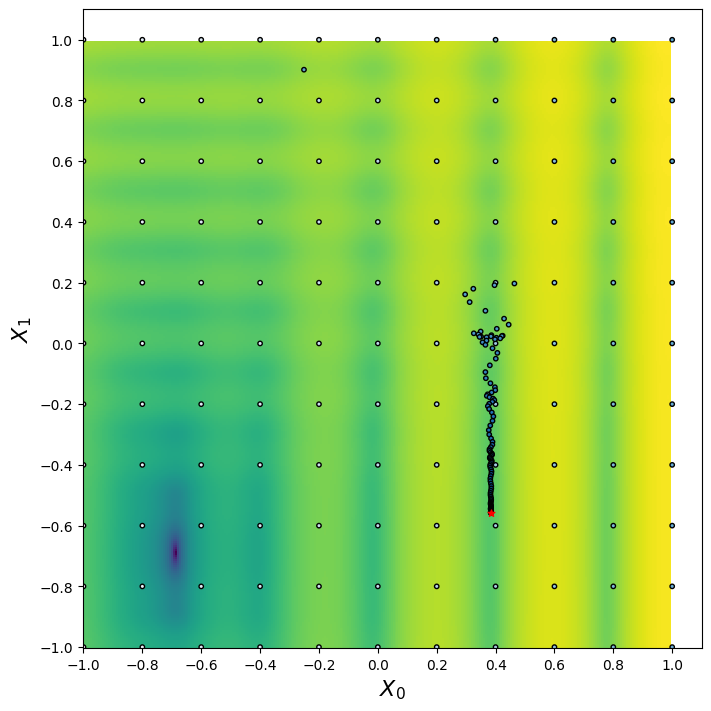

In [19]:
## SOLUTION ##

@dataclass
class Momentum_Exercise_Parameters(f3dasm.OptimizerParameters):
   """Example of hyperparameters"""

   momentum: float = 0.9
   learning_rate: float = 1e-4
   

class Momentum_Exercise(f3dasm.Optimizer):
   """Example of implement your own optimizer"""

   parameter: Momentum_Exercise_Parameters = Momentum_Exercise_Parameters()

   def init_parameters(self):
      """Set the initialization parameters. This could be dynamic or static hyperparameters."""
      self.velocity: np.ndarray = np.zeros(self.data.design.get_number_of_input_parameters())

   def update_step(self, function: f3dasm.Function) -> Tuple[np.ndarray, np.ndarray]:
      """Custom update step for your own optimizer

      Parameters
      ----------
      function
         objective function that is being optimized

      Returns
      -------
         tuple of resulting input and output parameter
      """

      x = self.data.get_input_data().iloc[-1].to_numpy()
    
      self.velocity = self.parameter.momentum * self.velocity  + self.parameter.learning_rate * function.dfdx(x)

      x_update = x - self.velocity

      # Format and force bounds
      x_update = np.atleast_2d(self._force_bounds(x_update))
      y_update = function(x_update)
      return x_update, y_update

iterations = 100

momentum_optimizer = Momentum_Exercise(data=copy.copy(samples))
function = f3dasm.functions.Levy(dimensionality=dimensionality, scale_bounds=design.get_bounds())
momentum_optimizer.iterate(iterations,function)
momentum_optimizer_data = momentum_optimizer.extract_data()

function.plot_data(data=momentum_optimizer_data, domain=design.get_bounds())

## Integrate your optimizer into the framework

The next step is to integrate your optimizer to the f3dasm code so that others can access them. 

### Adding the optimizer to the list of optimizers

In order to check if your implementation is compatible, you can add it to the list of implemented samplers
All the samplers can be accessed in a list by calling `f3dasm.sampling.OPTIMIZERS` 

> This list is created in the sub-module initializer`f3dasm.optimizer.__init__.py`

In [20]:
f3dasm.optimization.OPTIMIZERS

[f3dasm.optimization.cmaesadam.CMAESAdam,
 f3dasm.optimization.adam.Adam,
 f3dasm.optimization.sgd.SGD,
 f3dasm.optimization.cg.CG,
 f3dasm.optimization.cmaes.CMAES,
 f3dasm.optimization.differentialevolution.DifferentialEvolution,
 f3dasm.optimization.simulatedannealing.SimulatedAnnealing,
 f3dasm.optimization.lbfgsb.LBFGSB,
 f3dasm.optimization.neldermead.NelderMead,
 f3dasm.optimization.pso.PSO,
 f3dasm.optimization.randomsearch.RandomSearch,
 f3dasm.optimization.sga.SGA,
 f3dasm.optimization.sea.SEA,
 f3dasm.optimization.xnes.XNES,
 f3dasm.optimization.rmsprop.RMSprop,
 f3dasm.optimization.nadam.Nadam,
 f3dasm.optimization.adamax.Adamax,
 f3dasm.optimization.ftrl.Ftrl,
 f3dasm.optimization.sade.SADE]

### Adding the optimizer to the source code

You can create a new `.py` file in the `/f3dasm/optimization/` folder in the `f3dasm` repository with the optimizer

## End of the tutorial

This was the end of the second tutorial session on the f3dasm framework! Feel free to ask questions and give me feedback about this tutorial or the framework by [creating an issue on GitHub](https://github.com/bessagroup/F3DASM/issues)!